## NLP Tensor

[A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) (2003)

In [1]:
import random

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos, vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 27


In [4]:
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] 

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [5]:
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

block_size = 3

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182468, 3]) torch.Size([182468])
torch.Size([22849, 3]) torch.Size([22849])
torch.Size([22829, 3]) torch.Size([22829])


In [6]:
n_embd = 24
n_hidden = 128

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g) # Embedding

# Init weights & biases
w1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # Init scale using Kaiming initialization
b1 = torch.randn(n_hidden, generator=g) * 0.01
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, w1, b1, w2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

13475


In [7]:
# Estimate the initial loss value - Negative log of the probability distribution
-torch.tensor(1/vocab_size).log()

tensor(3.2958)

In [8]:
epochs = 200000
batch_size = 32
lossi = []

for i in range(epochs):

    # Minibatch - Embedding shape [32, 3, 2]
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y
    
    # Forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)

    h = torch.tanh(embcat @ w1 + b1)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

    # # Metrics
    if i % 10000 == 0:
        print(f'{i:7d} / {epochs:7d}: {loss.item():4f}')

    lossi.append(loss.log10().item())

      0 /  200000: 3.294645
  10000 /  200000: 2.547179
  20000 /  200000: 2.339882
  30000 /  200000: 2.196499
  40000 /  200000: 2.327451
  50000 /  200000: 2.281521
  60000 /  200000: 2.164529
  70000 /  200000: 2.215483
  80000 /  200000: 2.074398
  90000 /  200000: 2.370062
 100000 /  200000: 2.180112
 110000 /  200000: 2.308435
 120000 /  200000: 2.097538
 130000 /  200000: 1.817325
 140000 /  200000: 1.754988
 150000 /  200000: 1.691010
 160000 /  200000: 1.746645
 170000 /  200000: 2.135727
 180000 /  200000: 2.058752
 190000 /  200000: 2.089124


torch.Size([32, 128])


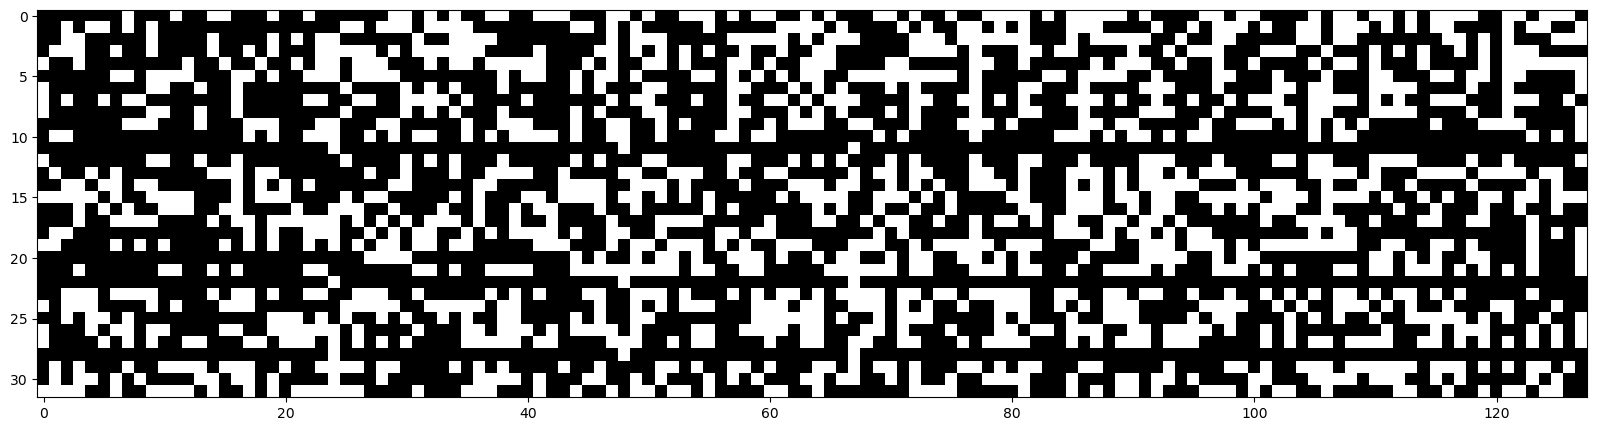

In [9]:
# Vizualize neurons in the hidden layer - 32 examples (batch size) across 200 neurons
print(h.shape)
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

(Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss'))

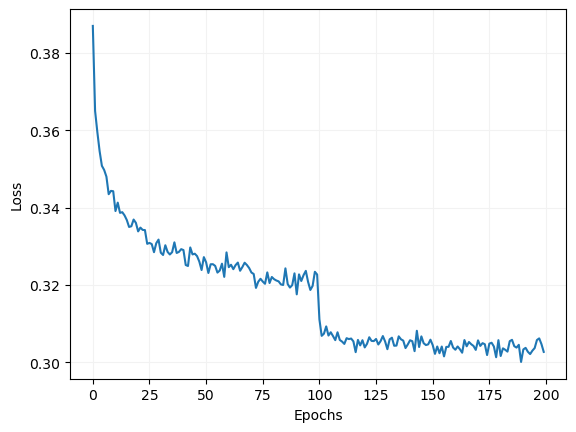

In [10]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1)) # Average lossi by factor epochs by 1000
plt.grid(axis='both', color='0.95')
plt.xlabel('Epochs'), plt.ylabel('Loss')

In [11]:
# Sample from the model
g = torch.Generator().manual_seed(123)
block_size = 3 # Context length

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        
        hidden = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = hidden @ w2 + b2

        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]

        out.append(ix)

        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

aylan.
jaydonandro.
kyrick.
ourya.
joanner.
deana.
adisilia.
drussel.
azzming.
edpe.
carmen.
dus.
has.
kasim.
ina.
vyelici.
jaquan.
keymonthi.
boluwaceonoraline.
mahd.


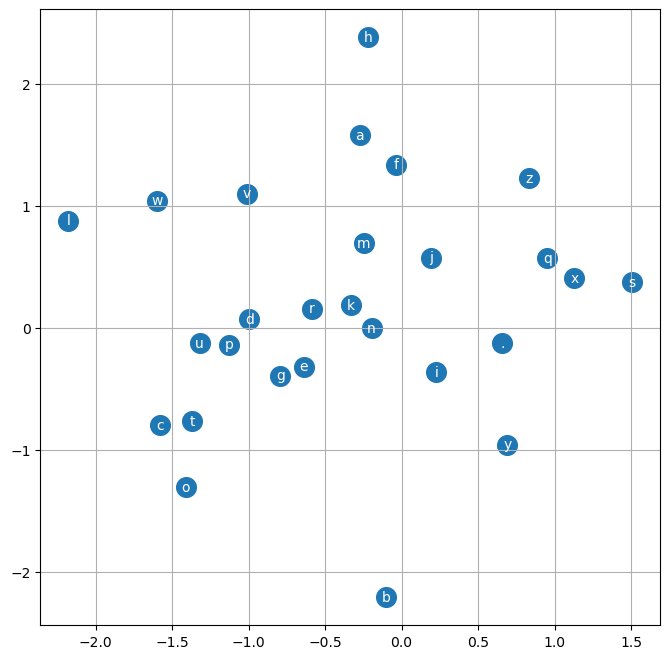

In [12]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')